In [1]:
import pandas
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, LSTM
from keras.utils import to_categorical
import nltk
nltk.download('averaged_perceptron_tagger')
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Using TensorFlow backend.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gerem\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [17]:
data = pandas.read_csv('train.csv')
data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### Preprocessing of the data : we replace the proper nouns with the word "Joker" thanks to nltk

In [3]:
sentences_preprocessed = data['text'].copy()
for (i, sentence) in enumerate(sentences_preprocessed):
    tagged_sentence = nltk.tag.pos_tag(sentence.split())
    edited_sentence = ' '.join([word if tag != 'NNP' else 'Joker' for word,tag in tagged_sentence])
    sentences_preprocessed.iloc[i] = edited_sentence

### Plotting of word clouds

In [4]:
def word_cloud(data, output):
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size= 80,width=800, height=400)
    wc.generate(" ".join(data))
    plt.title("Word Cloud before preprocessing", fontsize=20)
    plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
    plt.axis('off')
    plt.savefig(output)

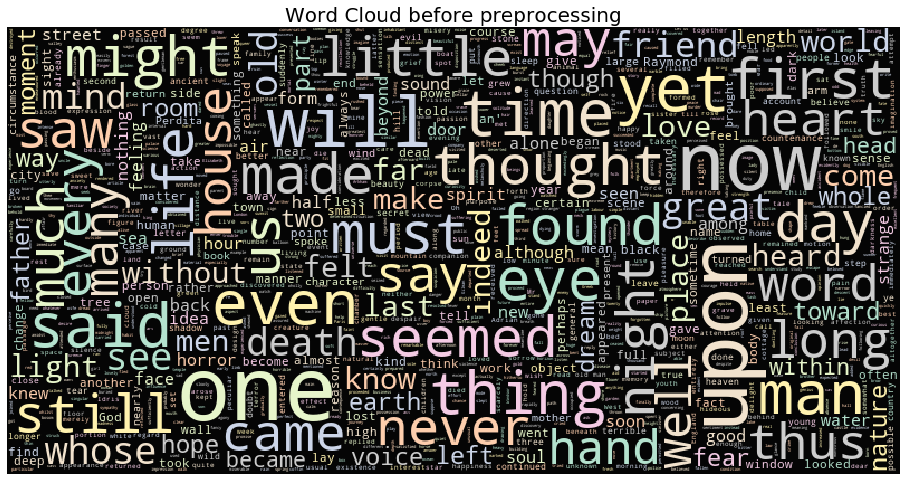

In [5]:
word_cloud(data['text'], "before.png")

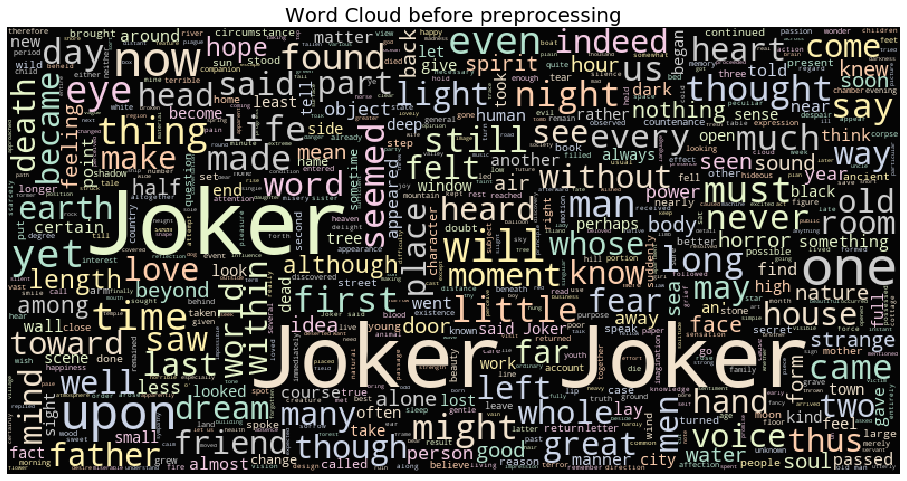

In [6]:
word_cloud(sentences_preprocessed, "after.png")

### Tokenization of sentences into arrays of integers

In [7]:
token = Tokenizer(num_words=None)
token.fit_on_texts(sentences_preprocessed)
sequences = token.texts_to_sequences(sentences_preprocessed)
num_words = max(max(seq) for seq in sequences)
sequences = pad_sequences(sequences)

### Transform the labels into integers

In [8]:
a2c = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
labels = np.array([a2c[a] for a in data.author])
labels = to_categorical(labels)

### Splitting the data into train set and test set

In [9]:
split = 2*len(data)//3
xtrain, xtest = sequences[:split], sequences[split:]
ytrain, ytest = labels[:split], labels[split:]

### Model definition

In [10]:
model = Sequential()
model.add(Embedding(num_words+1, 32))
model.add(GlobalAveragePooling1D())
#model.add(LSTM(32))
#model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          749600    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 749,699
Trainable params: 749,699
Non-trainable params: 0
_________________________________________________________________


In [11]:
optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Training

In [12]:
model.fit(xtrain, ytrain, epochs=5, validation_data=(xtest, ytest))

Train on 13052 samples, validate on 6527 samples
Epoch 1/5
13052/13052 [==============================] - 3s 243us/step - loss: 1.0699 - acc: 0.4241 - val_loss: 0.9931 - val_acc: 0.4780
Epoch 2/5
13052/13052 [==============================] - 2s 153us/step - loss: 0.8308 - acc: 0.6332 - val_loss: 0.7119 - val_acc: 0.6868
Epoch 3/5
13052/13052 [==============================] - 2s 153us/step - loss: 0.5887 - acc: 0.7725 - val_loss: 0.6163 - val_acc: 0.7376
Epoch 4/5
13052/13052 [==============================] - 2s 153us/step - loss: 0.4560 - acc: 0.8285 - val_loss: 0.5521 - val_acc: 0.7739
Epoch 5/5
13052/13052 [==============================] - 2s 154us/step - loss: 0.3810 - acc: 0.8526 - val_loss: 0.5129 - val_acc: 0.7870


### Loading of the pre-trained embedding

In [13]:
import os
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
embedding_matrix = np.zeros((num_words+1, 100))
word_index = token.word_index
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### New model for the pre-trained embedding

In [14]:
model2 = Sequential()
model2.add(Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            trainable=False))
model2.add(GlobalAveragePooling1D())
model2.add(Dense(3, activation='softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         2342500   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 2,342,803
Trainable params: 303
Non-trainable params: 2,342,500
_________________________________________________________________


In [15]:
optimizer2 = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Training with the pre-trained embedding

In [16]:
model2.fit(xtrain, ytrain, epochs=10, validation_data=(xtest, ytest))

Train on 13052 samples, validate on 6527 samples
Epoch 1/10
13052/13052 [==============================] - 2s 120us/step - loss: 1.0317 - acc: 0.4708 - val_loss: 1.0000 - val_acc: 0.5215
Epoch 2/10
13052/13052 [==============================] - 2s 121us/step - loss: 0.9885 - acc: 0.5268 - val_loss: 0.9743 - val_acc: 0.5540
Epoch 3/10
13052/13052 [==============================] - 1s 114us/step - loss: 0.9675 - acc: 0.5483 - val_loss: 0.9568 - val_acc: 0.5569
Epoch 4/10
13052/13052 [==============================] - 2s 122us/step - loss: 0.9524 - acc: 0.5627 - val_loss: 0.9450 - val_acc: 0.5846
Epoch 5/10
13052/13052 [==============================] - 1s 110us/step - loss: 0.9409 - acc: 0.5706 - val_loss: 0.9324 - val_acc: 0.5756
Epoch 6/10
13052/13052 [==============================] - 1s 113us/step - loss: 0.9315 - acc: 0.5793 - val_loss: 0.9233 - val_acc: 0.5862
Epoch 7/10
13052/13052 [==============================] - 2s 124us/step - loss: 0.9233 - acc: 0.5832 - val_loss: 0.9162 - v